In [3]:
import numpy as np
import tensorflow as tf
import zipfile

In [4]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-03-15 18:23:38--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.81.140.145, 2a02:26f0:6d00:6bf::e59, 2a02:26f0:6d00:688::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.81.140.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   117MB/s    in 6.9s    

2022-03-15 18:23:45 (114 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [5]:
import os

source_path = '/tmp/PetImages'
source_path_cats = os.path.join(source_path, 'Cat')
source_path_dogs = os.path.join(source_path, 'Dog')

print(len(os.listdir(source_path_cats)))
print(len(os.listdir(source_path_dogs)))

12501
12501


In [7]:
import shutil

root_dir = '/tmp/cat_vs_dog'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_test_dirs(root_path):
  
  os.makedirs(root_path + '/training')
  os.makedirs(root_path + '/testing')
  os.makedirs(root_path + '/training/cats')
  os.makedirs(root_path + '/training/dogs')
  os.makedirs(root_path + '/testing/cats')
  os.makedirs(root_path + '/testing/dogs')

create_train_test_dirs(root_dir)

In [8]:
import random
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  images = []
  for file in os.listdir(SOURCE):
    if os.path.getsize(SOURCE + file) == 0:
      print(file + ' is zero length, so ignoring.')
    else:
      images.append(file)

  shuffled_images = random.sample(images, len(images))

  train_length = int(len(shuffled_images) * SPLIT_SIZE)
  train_images = shuffled_images[:train_length]
  test_images = shuffled_images[train_length:]
  
  for file in train_images:
    copyfile(SOURCE + file, TRAINING + file)
  
  for file in test_images:
    copyfile(SOURCE + file, TESTING + file)

In [9]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cat_vs_dog/training/"
TESTING_DIR = "/tmp/cat_vs_dog/testing/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
  for file in os.scandir(TESTING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
  for file in os.scandir(TESTING_DOGS_DIR):
    os.remove(file.path)

split_size = .9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for testing
There are 1250 images of dogs for testing


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

val_datagen = ImageDataGenerator(rescale=1/255)

val_generator = val_datagen.flow_from_directory(directory=TESTING_DIR,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [11]:
model = tf.keras.models.Sequential([
                        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                        tf.keras.layers.MaxPooling2D(2,2),
                        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
                        tf.keras.layers.MaxPooling2D(2,2),
                        tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(150, 150, 3)),
                        tf.keras.layers.MaxPooling2D(2,2),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128),
                        tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(train_generator,
          epochs=15,
          validation_data=val_generator)

Epoch 1/15
  43/1125 [>.............................] - ETA: 3:39 - loss: 0.8933 - accuracy: 0.5233

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

1125/1125 [==============================] - 189s 163ms/step - loss: 0.6943 - accuracy: 0.5471 - val_loss: 0.6701 - val_accuracy: 0.5804
Epoch 2/15
1125/1125 [==============================] - 177s 157ms/step - loss: 0.6786 - accuracy: 0.5729 - val_loss: 0.6353 - val_accuracy: 0.6552
Epoch 3/15
1125/1125 [==============================] - 176s 157ms/step - loss: 0.6441 - accuracy: 0.6401 - val_loss: 0.5794 - val_accuracy: 0.7188
Epoch 4/15
1125/1125 [==============================] - 176s 157ms/step - loss: 0.5945 - accuracy: 0.6832 - val_loss: 0.4987 - val_accuracy: 0.7664
Epoch 5/15
1125/1125 [==============================] - 175s 156ms/step - loss: 0.5544 - accuracy: 0.7185 - val_loss: 0.4751 - val_accuracy: 0.7852
Epoch 6/15
1125/1125 [==============================] - 190s 168ms/step - loss: 0.5333 - accuracy: 0.7340 - val_loss: 0.4428 - val_accuracy: 0.7944
Epoch 7/15
1125/1125 [==============================] - 179s 159ms/step - loss: 0.5153 - accuracy: 0.7443 - val_loss: 0.462

In [ ]:
# 11250 color training images, with augmentation
# 3 Conv - MaxPooling layers
# 15 epochs
# Training time:  ~ 45 min
# Final Train/val accuracy: 0.81 / 0.84

In [16]:
import matplotlib.pyplot as plt

def create_val_plot(model_history):
        
    model_history = model_history.history

    # Training and validation loss plot
    loss_values = model_history['loss']
    val_loss_values = model_history['val_loss']

    epochs = range(1, len(loss_values) + 1)
    
    plt.figure()
    plt.plot(epochs, loss_values, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
        
    # Training and validation accuracy plot
    acc = model_history['accuracy']
    val_acc = model_history['val_accuracy']

    epochs = range(1, len(acc) + 1)
    
    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

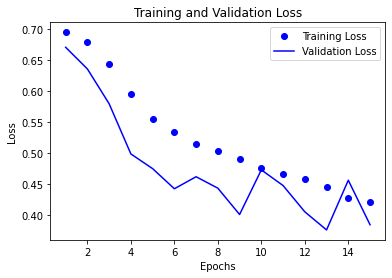

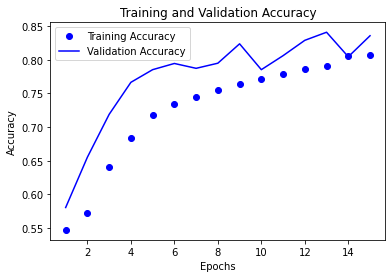

In [17]:
create_val_plot(history)

In [18]:
model.save('cnn_catsvsdogs.h5')

In [19]:
import os

def check_model_size(model_path, print_size=True):
    # # Get file size in bytes for a given model
    size = os.stat(model_path).st_size
    if print_size == True:
        print('Model size in bytes ', size)
    else:
        return size

check_model_size('cnn_catsvsdogs.h5')

Model size in bytes  57996920


In [24]:
import pandas as pd

def save_training_history(history, filename='model_training_history.csv'):
  history_dict = pd.DataFrame(history.history)
  history_dict.to_csv(filename)

save_training_history(history)

In [37]:
from tensorflow.keras.preprocessing import image

test_img = 'cat.jpg'

img = image.load_img(test_img, target_size = (150, 150))
img = image.img_to_array(img)
print('img shape: ', img.shape)

img = img / 255
img = np.expand_dims(img, axis = 0)
print('model input shape: ', img.shape)

prediction = model.predict(img)
print('Model predicted probability: ', prediction)
if prediction <= 0.5:
  print('Image is a cat')
else:
  print('Image is a dog')

img shape:  (150, 150, 3)
model input shape:  (1, 150, 150, 3)
Model predicted probability:  [[0.09621428]]
Image is a cat
